### Imports

In [1]:
# !pip install mne
# !pip install mne-connectivity

In [2]:
import os

import numpy as np

import mne
from mne.time_frequency import psd_welch

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import cross_val_score

from matplotlib import pyplot as plt

import gc

from joblib import Parallel
import time

In [29]:
import gc
import time
import os

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import regularizers
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sn

from tensorflow.python.client import device_lib


from sklearn.model_selection import cross_val_score

from matplotlib import pyplot as plt

## Preprocessing

### Loading edf

In [3]:
file = "..\dataverse_files\h01.edf"
edfs_path = "..\dataverse_files"
manifest_path = "..\dataverse_files\MANIFEST.txt"

In [4]:
def load_patients_data(edfs_path):
    raw_patients_data = []
    
    edfs_file_names = [f for f in os.listdir(edfs_path) if f.endswith('.edf')]
    
    for file_name in edfs_file_names:
        path = edfs_path + '\\' + file_name 
        raw_data = mne.io.read_raw_edf(path, preload=True, verbose=False)
        raw_patients_data.append(raw_data)

    return raw_patients_data

In [5]:
raw_patients_data = load_patients_data(edfs_path)

### Filtered EEG signals segmentation

In [6]:
def get_label(edf):
    patient_edf_file_name = edf.filenames[0].split('\\')[-1]
    isSick = patient_edf_file_name.lower().startswith('s')
    return int(isSick == True) # 1 - is sick, 0 is healthy

In [7]:
def print_info(epochs_num_per_patient, labels):
    print('\nEpochs number per patient: ', epochs_num_per_patient)
    
    class_0_num = sum(labels) 
    class_1_num = len(labels)-sum(labels)

    print('\nnegative: ', class_0_num)
    print('positive: ', class_1_num)

In [8]:
segment_duration = 1.0 # seconds

def transform_patients_data_into_X_y_sets(patients_data, info=True):
    epochs_per_patient = []
    labels = []
    
    epochs_num_per_patient = []
    for edf in raw_patients_data:
        epochs = mne.make_fixed_length_epochs(edf, duration=segment_duration, preload=True, verbose=False)
        epochs_per_patient.append(epochs)
        epochs_num_per_patient.append(len(epochs))
        
        label = get_label(edf)
        labels.extend([label for epoch in epochs])
    
    epochs = mne.concatenate_epochs(epochs_per_patient)

    if info:
        print_info(epochs_num_per_patient, labels)
        
    del epochs_num_per_patient
    gc.collect()
    
    return (epochs, np.array(labels)) # (X, y)

In [9]:
X, y = transform_patients_data_into_X_y_sets(raw_patients_data)
del raw_patients_data
gc.collect()

Not setting metadata
28863 matching events found
No baseline correction applied
0 bad epochs dropped

Epochs number per patient:  [925, 910, 910, 925, 945, 930, 910, 910, 905, 1115, 915, 900, 965, 865, 845, 1145, 964, 1205, 890, 740, 1346, 911, 1185, 850, 1360, 1087, 1135, 2170]

negative:  15833
positive:  13030


0

In [10]:
print(len(y))
print(len(X))
print(X[0].get_data().shape)

28863
28863
(1, 19, 250)


In [11]:
X.to_data_frame().head()

,time,condition,epoch,Fp2,F8,T4,T6,O2,Fp1,F7,...,O1,F4,C4,P4,F3,C3,P3,Fz,Cz,Pz
0,0,1,0,0.002500,0.002500,0.002500,0.00250,0.002500,0.0025,0.0025,...,0.00250,0.0025,0.002500,0.0025,0.0025,0.002500,0.00250,0.0025,0.0025,0.002500
1,4,1,0,0.002500,0.002500,0.002500,0.00250,0.002500,0.0025,0.0025,...,0.00250,0.0025,0.002500,0.0025,0.0025,0.002500,0.00250,0.0025,0.0025,0.002500
2,8,1,0,0.002500,0.002500,0.002500,0.00250,0.002500,0.0025,0.0025,...,0.00250,0.0025,0.002500,0.0025,0.0025,0.002500,0.00250,0.0025,0.0025,0.002500
3,12,1,0,0.461215,0.461215,0.308310,0.30831,0.155405,0.0025,0.0025,...,0.00250,0.0025,0.002500,0.0025,0.0025,-0.150405,-0.30331,0.0025,0.0025,-0.303310
4,16,1,0,0.461215,0.461215,0.461215,0.30831,0.155405,0.0025,0.0025,...,-0.30331,0.0025,0.155405,0.0025,0.0025,-0.150405,-0.30331,0.0025,0.0025,-0.150405


In [12]:
X[0].to_data_frame().head()

,time,condition,epoch,Fp2,F8,T4,T6,O2,Fp1,F7,...,O1,F4,C4,P4,F3,C3,P3,Fz,Cz,Pz
0,0,1,0,0.002500,0.002500,0.002500,0.00250,0.002500,0.0025,0.0025,...,0.00250,0.0025,0.002500,0.0025,0.0025,0.002500,0.00250,0.0025,0.0025,0.002500
1,4,1,0,0.002500,0.002500,0.002500,0.00250,0.002500,0.0025,0.0025,...,0.00250,0.0025,0.002500,0.0025,0.0025,0.002500,0.00250,0.0025,0.0025,0.002500
2,8,1,0,0.002500,0.002500,0.002500,0.00250,0.002500,0.0025,0.0025,...,0.00250,0.0025,0.002500,0.0025,0.0025,0.002500,0.00250,0.0025,0.0025,0.002500
3,12,1,0,0.461215,0.461215,0.308310,0.30831,0.155405,0.0025,0.0025,...,0.00250,0.0025,0.002500,0.0025,0.0025,-0.150405,-0.30331,0.0025,0.0025,-0.303310
4,16,1,0,0.461215,0.461215,0.461215,0.30831,0.155405,0.0025,0.0025,...,-0.30331,0.0025,0.155405,0.0025,0.0025,-0.150405,-0.30331,0.0025,0.0025,-0.150405


### Feature Extraction (Variance)

In [13]:
np.set_printoptions(precision=50)

In [14]:
for epoch in X:
    print (epoch.shape)
#     print(epoch)
#     print(epoch)
    break

(19, 250)


In [15]:
Input_N = X[0].get_data().shape[1] # input layer neurons number
print('Input_N: ', Input_N)

Output_N = 2 # classes: sick/positive = 1, not sick/negative = 0 // len(np.unique(y))
print('Output_N: ', Output_N)

Hidden_N = int(np.sqrt(Input_N*Output_N)) # neurons in hidden layer
print('Hidden_N: ', Hidden_N)

Input_N:  19
Output_N:  2
Hidden_N:  6


In [16]:
import statistics
from scipy import signal

for epoch in X:
    for channel in epoch:
        print(len(channel))
        print(np.var(channel))

        print(statistics.variance(channel)) 
        
        meanValue = statistics.mean(channel)
        print(statistics.variance(channel, meanValue))
        
#         welch = signal.welch(channel, fs=250.0, window='hann', 
#                            nperseg=None, noverlap=None, nfft=None, 
#                            detrend='constant', return_onesided=True, 
#                            scaling='density', axis=- 1, average='mean')
#         print(welch)
        
        break 
    break

250
1.0368472474442286e-10
1.0410112926146874e-10
1.0410112926146874e-10


In [17]:
# Calculating energy for signal segments
# X = np.array([[np.sqrt(statistics.variance(channel_data)) for channel_data in epoch] for epoch in X])
X = np.array([[np.sqrt(np.var(channel_data)) for channel_data in epoch] for epoch in X])

# X = np.array([[np.var(channel_data) for channel_data in epoch] for epoch in X])

In [18]:
print(np.max(X))
print(np.min(X))

0.0038604188705202718
0.0


In [19]:
print(np.max(X))
print(np.min(X))

0.0038604188705202718
0.0


In [20]:
from sklearn.preprocessing import MinMaxScaler

min_max_range = (0,1)
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

print(np.max(X))
print(np.min(X))

1.0
0.0


In [21]:
X.shape

(28863, 19)

In [22]:
print(len(X))
print(len(y))

28863
28863


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=1)

In [24]:
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)

X_train:  (24533, 19)
y_train:  (24533,)
X_test:  (4330, 19)
y_test:  (4330,)


In [25]:
# X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.18, shuffle=True, random_state=1)

In [26]:
# print('X_train: ', len(X_train))
# print('y_train: ', len(y_train))
# print('X_validation: ', len(X_validation))
# print('y_validation: ', len(y_validation))

# MLP with Keras - binary cross entropy

In [31]:
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout

# Input shape
input_shape = (Input_N,)

model = Sequential()
# tanh
model.add(Dense(100, input_shape=input_shape, activation='relu'))
model.add(Dense(100, input_shape=input_shape, activation='relu'))
model.add(Dense(100, input_shape=input_shape, activation='relu'))
# model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile()

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 100)               2000      
                                                                 
 dense_5 (Dense)             (None, 100)               10100     
                                                                 
 dense_6 (Dense)             (None, 100)               10100     
                                                                 
 dense_7 (Dense)             (None, 1)                 101       
                                                                 
Total params: 22,301
Trainable params: 22,301
Non-trainable params: 0
_________________________________________________________________


In [32]:
opt = tf.keras.optimizers.Adam(lr=0.001)

In [33]:
# Hyperparameters and training
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1, validation_split=0.18)

Epoch 1/100
81/81 [==============================] - 3s 9ms/step - loss: 0.6819 - accuracy: 0.5534 - val_loss: 0.6579 - val_accuracy: 0.5550
Epoch 2/100
81/81 [==============================] - 0s 6ms/step - loss: 0.6122 - accuracy: 0.6711 - val_loss: 0.5709 - val_accuracy: 0.6866
Epoch 3/100
81/81 [==============================] - 0s 5ms/step - loss: 0.5407 - accuracy: 0.7250 - val_loss: 0.4965 - val_accuracy: 0.7756
Epoch 4/100
81/81 [==============================] - 0s 5ms/step - loss: 0.4686 - accuracy: 0.7915 - val_loss: 0.4304 - val_accuracy: 0.8127
Epoch 5/100
81/81 [==============================] - 0s 5ms/step - loss: 0.4161 - accuracy: 0.8239 - val_loss: 0.3878 - val_accuracy: 0.8419
Epoch 6/100
81/81 [==============================] - 0s 5ms/step - loss: 0.3871 - accuracy: 0.8349 - val_loss: 0.3689 - val_accuracy: 0.8512
Epoch 7/100
81/81 [==============================] - 0s 5ms/step - loss: 0.3673 - accuracy: 0.8443 - val_loss: 0.3597 - val_accuracy: 0.8521
Epoch 8/100
8

Epoch 59/100
81/81 [==============================] - 0s 5ms/step - loss: 0.1765 - accuracy: 0.9339 - val_loss: 0.1656 - val_accuracy: 0.9368
Epoch 60/100
81/81 [==============================] - 0s 5ms/step - loss: 0.1802 - accuracy: 0.9316 - val_loss: 0.1640 - val_accuracy: 0.9398
Epoch 61/100
81/81 [==============================] - 0s 5ms/step - loss: 0.1778 - accuracy: 0.9325 - val_loss: 0.1565 - val_accuracy: 0.9434
Epoch 62/100
81/81 [==============================] - 0s 5ms/step - loss: 0.1718 - accuracy: 0.9355 - val_loss: 0.1607 - val_accuracy: 0.9400
Epoch 63/100
81/81 [==============================] - 0s 5ms/step - loss: 0.1688 - accuracy: 0.9356 - val_loss: 0.1621 - val_accuracy: 0.9389
Epoch 64/100
81/81 [==============================] - 0s 5ms/step - loss: 0.1725 - accuracy: 0.9334 - val_loss: 0.1659 - val_accuracy: 0.9373
Epoch 65/100
81/81 [==============================] - 0s 5ms/step - loss: 0.1737 - accuracy: 0.9333 - val_loss: 0.1510 - val_accuracy: 0.9447
Epoch 

In [42]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [43]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()


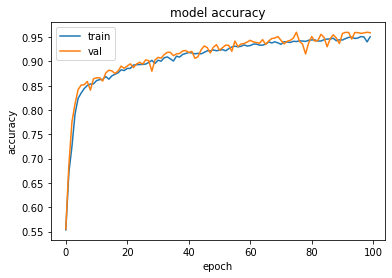

In [44]:
plot_accuracy(history)

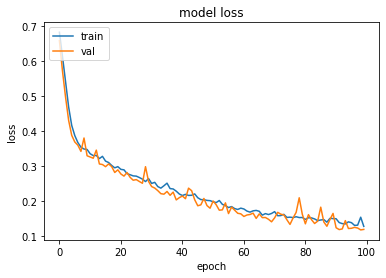

In [45]:
plot_loss(history)

In [46]:
predictions = model.predict(X_test, verbose=0)


In [47]:
predictions = np.array([0 if x < 0.5 else 1 for x in predictions])

In [48]:
print(len(predictions))
print(len(y_test))

4330
4330


In [49]:
print(predictions[0:15])
print(y_test[0:15])

[0 1 0 0 0 1 0 0 1 1 1 0 0 0 1]
[0 1 0 0 0 1 0 0 1 1 1 0 0 0 1]


In [50]:
accuracy = accuracy_score(y_test, predictions)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.9517321016166281


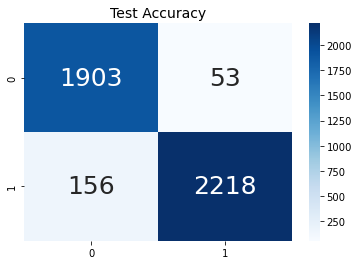

In [51]:
confusion_mtx = confusion_matrix(y_test, predictions)

ax = plt.axes()
sn.heatmap(confusion_mtx, annot=True,annot_kws={"size": 25}, cmap="Blues", ax = ax, fmt='d')
ax.set_title('Test Accuracy', size=14)
plt.show()

In [34]:
# Evaluation
test_results = model.evaluate(X_test, y_test, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}%')

136/136 [==============================] - 1s 4ms/step - loss: 0.1421 - accuracy: 0.9517
Test results - Loss: 0.14207203686237335 - Accuracy: 0.9517320990562439%


In [37]:
test_results

[0.14207203686237335, 0.9517320990562439]

In [38]:
y_test_pred = model.predict(X_test, verbose=1)

136/136 [==============================] - 0s 2ms/step


In [39]:
y_test_pred

array([[0.010252134 ],
       [0.8212989   ],
       [0.001059531 ],
       ...,
       [0.0055555357],
       [0.039224602 ],
       [0.99913627  ]], dtype=float32)

In [40]:
y_test_pred.reshape(4330, )

array([0.010252134 , 0.8212989   , 0.001059531 , ..., 0.0055555357,
       0.039224602 , 0.99913627  ], dtype=float32)

In [41]:
y_test

array([0, 1, 0, ..., 0, 0, 1])

In [436]:
y_test_pred.reshape(4330, ).shape

(4330,)

In [437]:
y_test.shape

(4330,)

In [438]:
from sklearn.metrics import confusion_matrix
conf_matrix = cm=confusion_matrix(y_test, y_test_pred.reshape(4330, ))
conf_matrix

array([[   0, 1956],
       [   0, 2374]], dtype=int64)

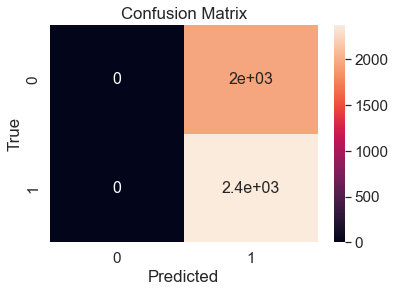

In [439]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(conf_matrix, annot=True, annot_kws={"size": 16}) # font size


plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

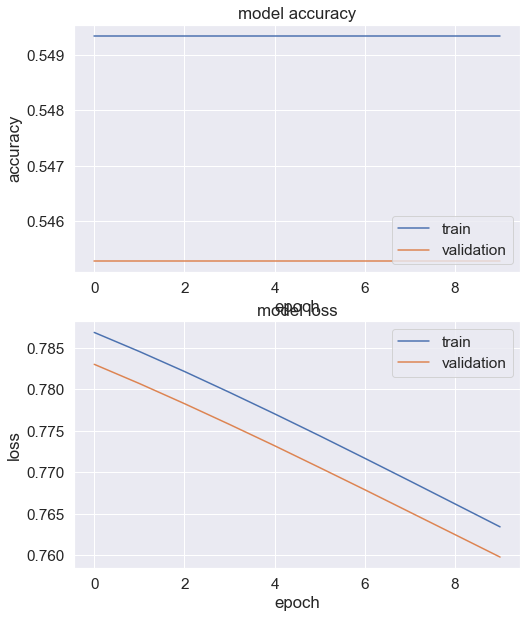

In [440]:
plt.figure(figsize=(8,10))
plt.subplot(2,1,1)

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')

plt.subplot(2,1,2)
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# MLP with Keras - categorical cross entropy

In [23]:
y_train = y_train.reshape((-1,1))
y_test = y_test.reshape((-1,1))

In [24]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, Output_N)
y_test = to_categorical(y_test, Output_N)

In [25]:
print('y_test: ', y_test.shape)
print('y_train: ', y_train.shape)

y_test:  (4330, 2)
y_train:  (24533, 2)


In [48]:
print(y_test[:5])
print(y_train[:5])

[[1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [136]:
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout

# Input shape
input_shape = (Input_N,)

model = Sequential()
# tanh
model.add(Dense(19, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(8, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(Output_N, activation='sigmoid'))

model.compile()
# model.build()
# model.summary()

In [137]:
X_train[0]

array([7.6116724437902457e-06, 7.6289325676352933e-06,
       4.7564604591893677e-06, 7.5360800474250402e-06,
       1.1849037506697505e-05, 8.9119453875280071e-06,
       9.7819357688341433e-06, 8.6886691563892504e-06,
       9.3811530319419248e-06, 1.0974306340387697e-05,
       6.8729003172278782e-06, 3.7655481722531202e-06,
       4.0515972295815452e-06, 7.0632732477763004e-06,
       4.5645178041536195e-06, 4.1881695617535823e-06,
       7.0817885865331797e-06, 4.6595055882064664e-06,
       3.5234543079113983e-06])

In [138]:
y_train[:5]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [139]:
# Hyperparameters and training
from keras.optimizers import SGD
opt = SGD(learning_rate=0.1)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, batch_size=250, verbose=1, validation_split=0.18)

Epoch 1/10
81/81 [==============================] - 0s 3ms/step - loss: 0.6889 - accuracy: 0.5473 - val_loss: 0.6891 - val_accuracy: 0.5453
Epoch 2/10
81/81 [==============================] - 0s 1ms/step - loss: 0.6884 - accuracy: 0.5493 - val_loss: 0.6891 - val_accuracy: 0.5453
Epoch 3/10
81/81 [==============================] - 0s 1ms/step - loss: 0.6883 - accuracy: 0.5493 - val_loss: 0.6890 - val_accuracy: 0.5453
Epoch 4/10
81/81 [==============================] - 0s 1ms/step - loss: 0.6884 - accuracy: 0.5493 - val_loss: 0.6890 - val_accuracy: 0.5453
Epoch 5/10
81/81 [==============================] - 0s 1ms/step - loss: 0.6884 - accuracy: 0.5493 - val_loss: 0.6890 - val_accuracy: 0.5453
Epoch 6/10
81/81 [==============================] - 0s 1ms/step - loss: 0.6883 - accuracy: 0.5493 - val_loss: 0.6892 - val_accuracy: 0.5453
Epoch 7/10
81/81 [==============================] - 0s 1ms/step - loss: 0.6883 - accuracy: 0.5493 - val_loss: 0.6890 - val_accuracy: 0.5453
Epoch 8/10
81/81 [==

In [123]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 19)                380       
                                                                 
 dense_28 (Dense)            (None, 8)                 160       
                                                                 
 dense_29 (Dense)            (None, 2)                 18        
                                                                 
Total params: 558
Trainable params: 558
Non-trainable params: 0
_________________________________________________________________


In [124]:
# Evaluation
test_results = model.evaluate(X_test, y_test, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}%')

136/136 [==============================] - 0s 831us/step - loss: 0.6886 - accuracy: 0.5483
Test results - Loss: 0.6885995268821716 - Accuracy: 0.5482679009437561%


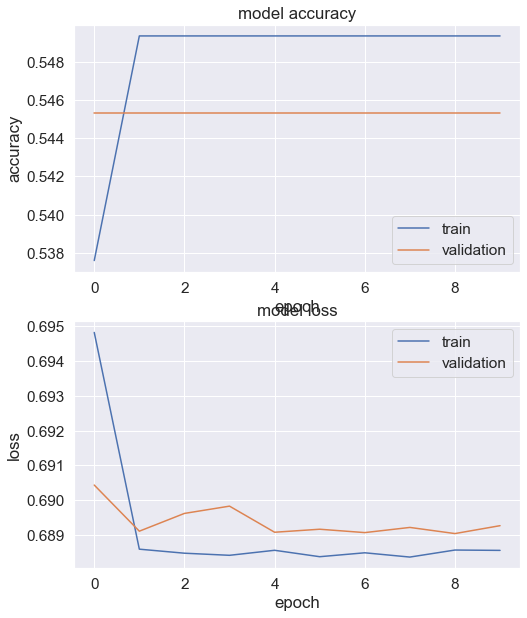

In [125]:
plt.figure(figsize=(8,10))
plt.subplot(2,1,1)

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')

plt.subplot(2,1,2)
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [126]:
y_test_pred = model.predict(X_test, verbose=1)

136/136 [==============================] - 0s 643us/step


In [127]:
y_test.shape

(4330, 2)

In [128]:
print(y_test)

[[1. 0.]
 [0. 1.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]


In [129]:
y_test_pred.shape

(4330, 2)

In [130]:
print(y_test_pred)

[[0.5659718  0.6201466 ]
 [0.5659718  0.6201465 ]
 [0.56597143 0.6201466 ]
 ...
 [0.5659718  0.6201466 ]
 [0.5659719  0.6201466 ]
 [0.5659719  0.62014645]]


In [131]:
(y_test_pred > 0.5).astype(int)

array([[1, 1],
       [1, 1],
       [1, 1],
       ...,
       [1, 1],
       [1, 1],
       [1, 1]])

In [132]:
y_test_pred_continuous = np.array([0 if val[0]==1 else 1 for val in (y_test_pred > 0.5).astype(int)])

In [133]:
y_test_continuous = np.array([0 if val[0]==1 else 1 for val in (y_test > 0.5).astype(int)])

In [134]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test_continuous, y_test_pred_continuous)
conf_matrix

array([[1956,    0],
       [2374,    0]], dtype=int64)

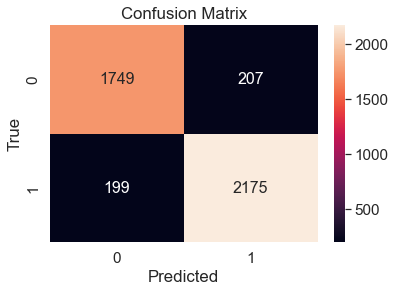

In [58]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(conf_matrix, annot=True, annot_kws={"size": 16}, fmt='d') # font size


plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Sklearn MLP Classifier

In [47]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
# X, y = make_classification(n_samples=100, random_state=1)
# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
#                                                      random_state=1)

clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
# clf.predict_proba(X_test[:1])

# clf.predict(X_test[:5, :])

# clf.score(X_test, y_test)


E:\Users\dt\anaconda3\envs\ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [50]:
train_loss_ = clf.loss_curve_

In [25]:
clf.predict_proba(X_test[:1])


array([[0.9441024535253673  , 0.055897546474632694]])

In [55]:
y_test_pred = clf.predict(X_test)


In [56]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
conf_matrix

array([[1749,  207],
       [ 199, 2175]], dtype=int64)

In [51]:
clf.score(X_test, y_test)


0.9062355658198614

In [29]:
clf.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 300,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 1,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [ ]:
clf.loss_curve_

In [46]:
# clf.loss_curve_
clf.predict()

'log_loss'

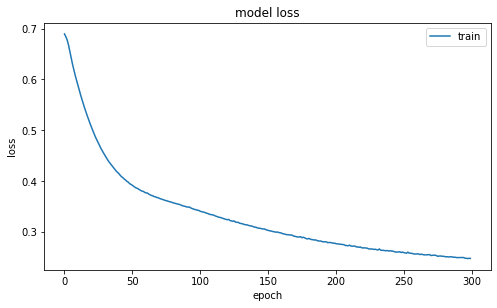

In [53]:
plt.figure(figsize=(8,10))

plt.subplot(2,1,2)
# summarize history for loss
plt.plot(train_loss_)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

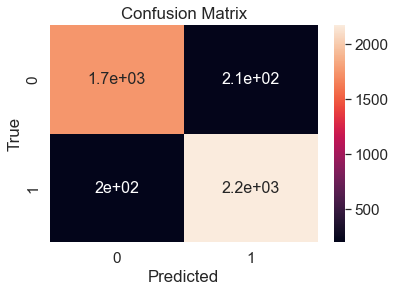

In [57]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(conf_matrix, annot=True, annot_kws={"size": 16}) # font size


plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Data preparation

In [2]:
x_data = X.get_data()
x_data.shape

AttributeError: 'numpy.ndarray' object has no attribute 'get_data'

In [ ]:
column_names = X[0].to_data_frame().columns
column_names = column_names[-19:]
column_names

In [ ]:
epoch_num, channel_num, epoch_len = x_data.shape

In [ ]:
def shift_bit_length(x):
    return 1<<(x-1).bit_length()

In [ ]:
shift_bit_length(16)

In [ ]:
# create spec for all segments v3 flatten segments before creating spectrogram
from scipy import signal

from scipy.fft import fftshift

import matplotlib.pyplot as plt

from matplotlib import mlab

from matplotlib.colors import Normalize as norm

from sklearn.preprocessing import MinMaxScaler

from math import floor

from scipy.io import savemat


#single_channel = np.array(epoch[:, 3], dtype=np.float64)

dpi = 100
px = 1/dpi

def create_spectrogram(x, filename):
    print(x.shape)

    signal_data = np.array([])
    
    for i in range(len(x)):
        signal_data = np.concatenate((signal_data, x[i]))
        

    mdic = {"signal_data": signal_data, "label": "eeg"}

    savemat("../files/matlab_matrix.mat", mdic)
    
    x = signal_data


    fs = 250
    Nx = len(x);
    nsc = floor(Nx/4.5);
    nov = floor(nsc/2);
    nff = max(256,shift_bit_length(nsc));
    window=('hamming')
    mode='psd'
    
    print('Nx: ', Nx)
    print('nsc: ', nsc)
    print('nov: ', nov)
    print('nff: ', nff)
    print('shift_bit_length(nsc): ', shift_bit_length(nsc))

#     n_per_seg = floor(len(signal_data)/4.5)
#     no_overlap = floor(n_per_seg/2) # 5s long
    
#     print(no_overlap)
    
#     N = 1024;
#     n = 0:N-1;

#     w0 = 2*pi/5;
#     x = sin(w0*n)+10*sin(2*w0*n);


#     w0 = 2*np.pi/5;
#     x = np.sin(w0*signal_data)+10*np.sin(2*w0*signal_data);

    f, t, Sxx = signal.spectrogram(x=x, fs=fs, nperseg=nsc, noverlap=nov, nfft=nff,
                                   window=window,return_onesided=False, mode=mode) #scaling='spectrum'
    
    np.savetxt('../files/scipy_Sxx', Sxx)
    np.savetxt('../files/scipy_f', f)
    np.savetxt('../files/scipy_t', t)
    
#     f = np.sort(f)

    f1 = f
    Sxx1= Sxx

    plt.figure(figsize=(8, 4), dpi=1200)

    plt.pcolormesh(t, fftshift(f), fftshift(Sxx, axes=0), shading='auto', cmap='jet')

    plt.ylabel('Frequency [Hz]')

    plt.xlabel('Time [sec]')

#     plt.axis('off')

    plt.show()
    

    
    print('x', type(signal_data), signal_data.shape)
    
    print('f', type(f), f.shape)
#     print(f)
    print('t', type(t), t.shape)
    #     print(t)
    print('sxx', type(Sxx), Sxx.shape)
    print(Sxx)
    
#     Fs = 250
# #     tWindow = 64e-3
#     tWindow = 1
#     NWindow = Fs*tWindow
    window = np.hamming(nff)
#     NFFT = 250
#     NOverlap = NWindow/2
#     mode='psd'
    
#     print('window', window.shape, ' tWindow ', tWindow)

    Sxx, f, t = mlab.specgram(x, NFFT = nff, Fs = fs, 
                              window = window, noverlap = nov, mode=mode, sides='twosided') #scale_by_freq=True
    
    np.savetxt('../files/mlab_Sxx', Sxx)
    np.savetxt('../files/mlab_f', f)
    np.savetxt('../files/mlab_t', t)
    
    
#     plt.specgram(signal_data, NFFT = NFFT, Fs = Fs, 
#                  window = window, noverlap = NOverlap, mode='psd', sides='twosided', scale_by_freq=True)
#     f, t, Sxx = mlab.specgram(signal_data, Fs = Fs)



    print('f', type(f), f.shape)
#     print(f)
    print('t', type(t), t.shape)
    #     print(t)
    print('sxx', type(Sxx), Sxx.shape)
#     print(Sxx)
        
    
#     freq = np.sort(freq)
#     print('f', type(f), f.shape)
#     print(f)
#     print('t', type(t), t.shape)
#     print(t)
#     print('Sxx', type(Sxx), Sxx.shape)
#     print(Sxx)

    print('min', np.amin(f))
    print('max', np.amax(f))

#     f = f*2*3.14/250
    
#     f = f.reshape(-1, 1)

#     scaler = MinMaxScaler(feature_range=(0, 1), copy=True)
#     scaler.fit(f)
#     f = scaler.transform(f)


#     f = f.reshape(1, -1)[0]

    print('min', np.amin(f))
    print('max', np.amax(f))


    plt.figure(figsize=(8, 4), dpi=1200)

    plt.pcolormesh(t, fftshift(f1), fftshift(Sxx, axes=0), shading='auto', cmap='jet')

    plt.ylabel('Frequency [Hz]')

    plt.xlabel('Time [sec]')

#     plt.axis('off')

    plt.show()
#     plt.savefig(filename + '.png', bbox_inches='tight', pad_inches=0, transparent=True, dpi=1000)
    
#     plt.close()
    
#     plt.cla()
#     plt.clf()

    np.setdiff1d(Sxx, Sxx1)

In [ ]:
create_spectrogram(x_data[0], '../spectrograms/aaa')

In [ ]:
def get_spectrogram(epoch_index, label, epoch_data):
    print('get_spectrogram')
    filename = path.format(
        epoch_index,
        label)

    print(filename)
    print(epoch_data.shape)
    if(not os.path.isfile(filename+png_extension)):
        create_spectrogram(epoch_data, filename)

In [ ]:
from joblib import Parallel, delayed

# generating spectrograms parallel

path = '../spectrograms/{0}_{1}'
png_extension = '.png'

Parallel(n_jobs=1)(delayed(get_spectrogram)(epoch_index=epoch_index,
                                    label = y[epoch_index],
                                    epoch_data=x_data[epoch_index]
                                   ) for epoch_index in range(1))

In [ ]:
'''
  TensorFlow 2 based Keras model discussing Binary Cross Entropy loss.
'''
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_circles

# Configuration options
num_samples_total = 1000
training_split = 250
loss_function_used = BinaryCrossentropy()

# Configuration options
num_samples_total = 1000
training_split = 250
loss_function_used = BinaryCrossentropy()

In [3]:
# Generate data
X, targets = make_circles(n_samples = num_samples_total, factor=0.1)
X_training = X[training_split:, :]
X_testing = X[:training_split, :]
Targets_training = targets[training_split:]
Targets_testing = targets[:training_split]

NameError: name 'make_circles' is not defined

In [195]:
X.shape

(1000, 2)

In [196]:
targets.shape

(1000,)

In [198]:
X

array([[-0.0754251380736104  ,  0.06565857557529564 ],
       [-0.8163392507171838  , -0.5775727034222677  ],
       [ 0.41437558099328403 ,  0.9101059706849958  ],
       ...,
       [ 0.693653305812805   , -0.7203090248879068  ],
       [-0.025130095443336987, -0.9996841892833     ],
       [-0.7459411454241821  ,  0.6660118674342517  ]])

In [199]:
targets

array([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1,